In [1]:
import time
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from scipy.fftpack import fft
import pandas as pd
import seaborn as sns
import math
import sys
import os
from sabreMod import sosf,sosfh
from scipy import interpolate

plt.rcParams["font.family"]="Times New Roman"
plt.rcParams["font.size"]="20"

In [2]:
start=time.time()

In [3]:
lagoon=pd.read_table('Obs/LagoonHaenel.csv', delimiter=',')
lagoon.describe()

,1,2,3,4,5,6,7,8,9,10,...,24,25,26,27,28,29,30,31,32,33
count,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,...,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000
mean,0.100000,0.070370,0.248148,0.822222,0.362963,1.833333,1.266667,1.514815,1.885185,2.459259,...,3.122222,1.866667,2.029630,2.040741,1.270370,0.977778,0.155556,0.266667,0.029630,-0.003704
std,0.519615,0.262847,2.137822,1.771426,1.854754,3.045299,2.405283,2.926235,3.130582,2.558885,...,2.902430,2.174856,2.008791,1.876219,2.435762,1.413760,1.219815,1.012993,0.485018,0.208440
min,0.000000,0.000000,-5.300000,0.000000,-3.300000,-4.300000,-2.300000,-3.300000,-6.300000,-2.300000,...,-0.800000,-1.300000,-2.300000,-1.300000,-2.400000,-0.400000,-4.800000,-1.100000,-1.300000,-0.800000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.450000,0.350000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.700000,1.700000,...,3.200000,1.400000,1.700000,2.000000,0.700000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.100000,0.200000,3.700000,3.200000,3.700000,4.300000,4.700000,...,4.650000,3.550000,3.100000,3.700000,2.850000,1.700000,0.500000,0.000000,0.000000,0.000000
max,2.700000,1.200000,5.700000,6.700000,5.700000,9.700000,6.700000,9.700000,7.700000,7.600000,...,11.700000,6.700000,6.700000,5.700000,9.700000,4.700000,2.500000,4.000000,1.400000,0.700000


In [4]:
#orion[orion == 0] = 'nan' 
#orion

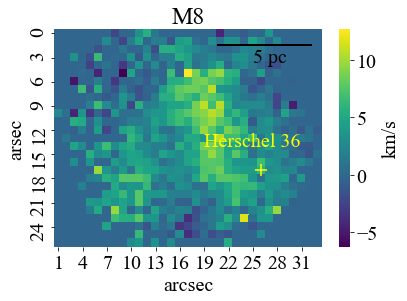

In [5]:
fig, ax = plt.subplots()
sns.heatmap(lagoon,cmap="viridis",cbar_kws={'label': 'km/s'})

plt.scatter(25.5, 17.5, marker='+', color='yellow', s=150)

ax.set(xlabel='arcsec', ylabel='arsec')

ax.text(0.87, 0.83, '5 pc',
        verticalalignment='bottom', horizontalalignment='right',
      transform=ax.transAxes,
       color='black', fontsize=20)
    
plt.axhline(y=2, xmin=0.61, xmax=0.96, linewidth=2, color = 'k')

plt.text(18.5, 14.5, 'Herschel 36', fontsize=20, color='yellow')

plt.title('M8')
plt.show()

In [6]:
df=lagoon.stack().reset_index().rename(columns={'level_0':'RAdeg', 'level_1':'DEdeg', 0:'RVHalpha'})
df.describe()

,RAdeg,RVHalpha
count,891.000000,891.000000
mean,13.000000,2.040853
std,7.793256,2.841604
min,0.000000,-6.300000
25%,6.000000,0.000000
50%,13.000000,0.900000
75%,20.000000,3.700000
max,26.000000,12.700000


In [7]:
df.RAdeg=1.0*df.RAdeg

In [8]:
df.DEdeg=pd.to_numeric(df.DEdeg)*1.0

Structure Function

In [9]:
df0 = pd.DataFrame({'X': df.RAdeg, 'Y': df.DEdeg, 'RV': df.RVHalpha})
df0.describe()

,X,Y,RV
count,891.000000,891.000000,891.000000
mean,13.000000,17.000000,2.040853
std,7.793256,9.527252,2.841604
min,0.000000,1.000000,-6.300000
25%,6.000000,9.000000,0.000000
50%,13.000000,17.000000,0.900000
75%,20.000000,25.000000,3.700000
max,26.000000,33.000000,12.700000


In [10]:
df0["RV"] = df0["RV"].replace(['0', 0], np.nan)


In [11]:
df0.describe()

,X,Y,RV
count,891.000000,891.000000,566.000000
mean,13.000000,17.000000,3.212721
std,7.793256,9.527252,2.991306
min,0.000000,1.000000,-6.300000
25%,6.000000,9.000000,1.200000
50%,13.000000,17.000000,3.200000
75%,20.000000,25.000000,5.000000
max,26.000000,33.000000,12.700000


In [12]:
data=df0

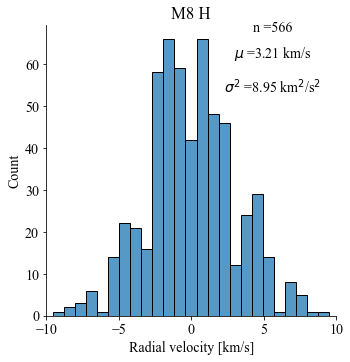

In [41]:
#fig, ax = plt.subplots()

sns.displot(data.RV-data.RV.mean(),bins=25)
plt.xlim(-10,10)


plt.text(0.45, 0.86,'n ='+str(data.RV.count()), ha='center', va='center', transform=ax.transAxes, color='k')
plt.text(0.45, 0.78,'$μ$ ='+str(np.round(data.RV.mean(),2))+' km/s', ha='center', va='center', transform=ax.transAxes, color='k')
plt.text(0.45, 0.68,'$σ^{2}$ ='+str(np.round(data.RV.var(),2))+' km$^{2}$/s$^{2}$', ha='center', va='center', transform=ax.transAxes, color='k')

plt.title('M8 H')

plt.rcParams["font.family"]="Times New Roman"
plt.rcParams["font.size"]="14"

plt.xlabel('Radial velocity [km/s]')
plt.savefig('Hist//M8H.pdf', bbox_inches='tight')

In [14]:
pc=.41

C:\Users\ZAINTEL2\Dropbox\Articulos\PhD\Master\sabreMod.py:75: RuntimeWarning: invalid value encountered in greater
  ind=np.squeeze(d[:,1])>0.0


1.0


[None, None]

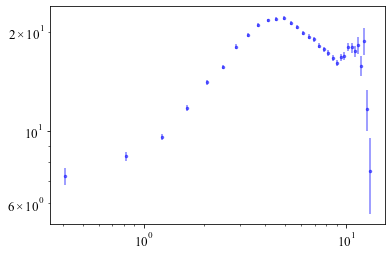

In [15]:
data=df0
SF=sosf(data)
SF.Lag=SF.Lag*pc

fig,ax=plt.subplots()

ax.errorbar(SF.Lag,SF.Nmqvd, yerr=SF.ErrY, marker='.', fmt=' ',color="blue", ecolor="blue",
                     alpha=0.5, markersize=5)

ax.set(xscale='log',yscale='log')

In [16]:
dfx = SF[['Lag', 'Nmqvd','ErrX','ErrY']].copy()
dfx=dfx.rename(columns={"Lag": "pc", "Nmqvd": "S"})
dfx.to_csv('SFdata//M8H1.csv',mode = 'w', index=False)

In [17]:
#x=SF['Lag']
#y=SF['Nmqvd']-(data["RV"].std())**2
#tck=interpolate.splrep(x,y,s=0)
#grid=np.linspace(x.min(),x.max(),num=len(x))
#ynew=interpolate.splev(grid,tck,der=0)
#inter=pd.DataFrame([grid,ynew]).T
#SFr=interpolate.sproot(tck)
#SFr

In [18]:
#x=np.linspace((SF.Lag.min()),(SF.Lag.max()),100)
#c=1/(1+(x/lo)**n)
#y=2*(1-c)*ss
#plt.loglog(x,y,color='k', linestyle='-')

Dr. Will

In [19]:
df1 = pd.DataFrame({'RA': df.RAdeg, 'DE': df.DEdeg, 'V': df.RVHalpha, '_key': 1})
df1.describe()

,RA,DE,V,_key
count,891.000000,891.000000,891.000000,891.0
mean,13.000000,17.000000,2.040853,1.0
std,7.793256,9.527252,2.841604,0.0
min,0.000000,1.000000,-6.300000,1.0
25%,6.000000,9.000000,0.000000,1.0
50%,13.000000,17.000000,0.900000,1.0
75%,20.000000,25.000000,3.700000,1.0
max,26.000000,33.000000,12.700000,1.0


In [20]:
df2 = df1.copy()

In [21]:
pairs = pd.merge(df1, df2, on='_key', suffixes=('', '_')).drop('_key', 1)
pairs.index = pd.MultiIndex.from_product((df1.index, df2.index))

pairs.head()

RA   DE    V  RA_  DE_   V_
0 0  0.0  1.0  0.0  0.0  1.0  0.0
  1  0.0  1.0  0.0  0.0  2.0  0.0
  2  0.0  1.0  0.0  0.0  3.0  0.0
  3  0.0  1.0  0.0  0.0  4.0  0.0
  4  0.0  1.0  0.0  0.0  5.0  0.0

In [22]:
pairs.loc[:, 'dDE'] =(pairs.DE - pairs.DE_)
pairs.loc[:, 'dRA'] = (pairs.RA - pairs.RA_)*np.cos(np.radians(0.5*(pairs.DE + pairs.DE_)))
pairs.loc[:, 's'] = np.hypot(pairs.dRA, pairs.dDE)
pairs.loc[:, 'log_s'] = np.log10(pairs.s)
pairs.loc[:, 'dV'] = pairs.V - pairs.V_
pairs.loc[:, 'dV2'] = pairs.dV**2
pairs.loc[:, 'log_dV2'] = np.log10(pairs.dV**2)
pairs.loc[:, 'VV_mean'] = 0.5*(pairs.V + pairs.V_)

C:\Users\ZAINTEL2\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [23]:
pairs = pairs[(pairs.dDE > 0.0) & (pairs.dRA > 0.0)]
pairs.head()

RA   DE    V  RA_  DE_   V_  dDE       dRA         s     log_s   dV  \
34 0  1.0  2.0  0.0  0.0  1.0  0.0  1.0  0.999657  1.413971  0.150441  0.0   
35 0  1.0  3.0  0.0  0.0  1.0  0.0  2.0  0.999391  2.235796  0.349432  0.0   
   1  1.0  3.0  0.0  0.0  2.0  0.0  1.0  0.999048  1.413541  0.150308  0.0   
36 0  1.0  4.0  0.0  0.0  1.0  0.0  3.0  0.999048  3.161977  0.499959  0.0   
   1  1.0  4.0  0.0  0.0  2.0  0.0  2.0  0.998630  2.235455  0.349366  0.0   

      dV2  log_dV2  VV_mean  
34 0  0.0     -inf      0.0  
35 0  0.0     -inf      0.0  
   1  0.0     -inf      0.0  
36 0  0.0     -inf      0.0  
   1  0.0     -inf      0.0

In [24]:
pairs.describe()

,RA,DE,V,RA_,DE_,V_,dDE,dRA,s,log_s,dV,dV2,log_dV2,VV_mean
count,185328.000000,185328.000000,185328.000000,185328.000000,185328.000000,185328.000000,185328.000000,185328.000000,185328.000000,185328.000000,185328.000000,185328.000000,1.853280e+05,185328.000000
mean,17.666667,22.666667,2.161731,8.333333,11.333333,1.869457,11.333333,8.865969,15.713753,1.135897,0.292273,16.470942,-inf,2.015594
std,6.236112,7.652181,2.791378,6.236112,7.652181,2.907110,7.652181,5.936462,7.343369,0.251186,4.047914,24.365922,NaN,2.006275
min,1.000000,2.000000,-6.300000,0.000000,1.000000,-6.300000,1.000000,0.843391,1.308170,0.116664,-17.500000,0.000000,-inf,-5.550000
25%,13.000000,17.000000,0.000000,3.000000,5.000000,0.000000,5.000000,3.845047,10.041642,1.001805,-2.200000,0.810000,-9.151498e-02,0.350000
50%,19.000000,24.000000,1.200000,7.000000,10.000000,0.700000,10.000000,7.810368,15.276035,1.184011,0.000000,7.290000,8.627275e-01,1.850000
75%,23.000000,29.000000,3.700000,13.000000,17.000000,3.700000,17.000000,12.980574,21.018613,1.322604,2.800000,22.090000,1.344196e+00,3.350000
max,26.000000,33.000000,12.700000,25.000000,32.000000,12.700000,32.000000,25.991090,40.524248,1.607715,18.000000,324.000000,2.510545e+00,12.200000


In [25]:
pairs.corr()

,RA,DE,V,RA_,DE_,V_,dDE,dRA,s,log_s,dV,dV2,log_dV2,VV_mean
RA,1.000000e+00,-7.704777e-15,-0.226461,5.000000e-01,-3.261592e-15,0.122120,-3.328947e-15,0.498937,0.270226,0.271687,-0.243867,-0.061118,-0.006094,-0.069064
DE,-7.704777e-15,1.000000e+00,-0.250083,-3.230412e-15,5.000000e-01,0.186530,5.000000e-01,-0.042961,0.378313,0.337899,-0.306414,-0.034266,-0.066549,-0.038831
V,-2.264608e-01,-2.500825e-01,1.000000,-1.132304e-01,-1.250413e-01,-0.008782,-1.250413e-01,-0.101228,-0.175703,-0.129463,0.695891,0.374091,0.269969,0.689299
RA_,5.000000e-01,-3.230412e-15,-0.113230,1.000000e+00,-1.579251e-15,0.244239,-1.624953e-15,-0.498937,-0.270226,-0.271687,-0.253488,-0.025329,0.000986,0.098182
DE_,-3.261592e-15,5.000000e-01,-0.125041,-1.579251e-15,1.000000e+00,0.373060,-5.000000e-01,-0.048635,-0.439222,-0.399173,-0.354149,0.003194,-0.059103,0.183297
V_,1.221197e-01,1.865300e-01,-0.008782,2.442394e-01,3.730600e-01,1.000000,-1.865300e-01,-0.137050,-0.241179,-0.198507,-0.724231,0.165586,0.140670,0.718395
dDE,-3.328947e-15,5.000000e-01,-0.125041,-1.624953e-15,-5.000000e-01,-0.186530,1.000000e+00,0.005673,0.817535,0.737072,0.047735,-0.037461,-0.005792,-0.222128
dRA,4.989369e-01,-4.296130e-02,-0.101228,-4.989369e-01,-4.863468e-02,-0.137050,5.673380e-03,1.000000,0.546208,0.547681,0.028621,-0.034325,-0.003123,-0.169714
s,2.702262e-01,3.783134e-01,-0.175703,-2.702262e-01,-4.392218e-01,-0.241179,8.175353e-01,0.546208,1.000000,0.941273,0.052047,-0.063033,-0.015147,-0.296966
log_s,2.716869e-01,3.378992e-01,-0.129463,-2.716869e-01,-3.991732e-01,-0.198507,7.370724e-01,0.547681,0.941273,1.000000,0.053287,-0.002671,0.026596,-0.233882


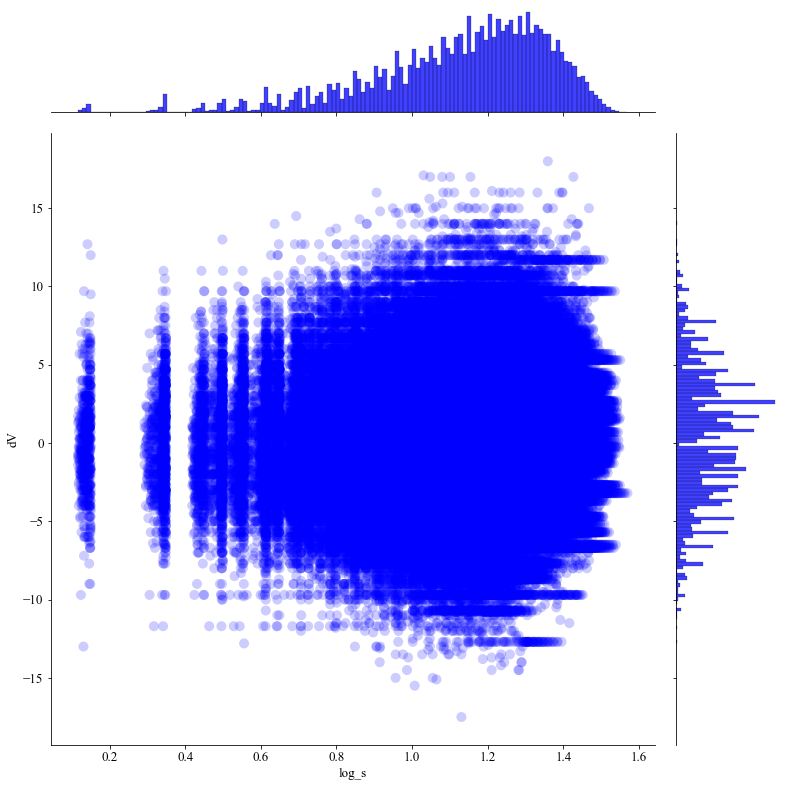

In [26]:
mask = (pairs.log_s > 0) & (pairs.log_dV2 > -4)
ax = sns.jointplot(x='log_s', y='dV', data=pairs[mask], alpha=0.2, s=100, edgecolor='none',color="blue")
ax.fig.set_size_inches(12, 12)

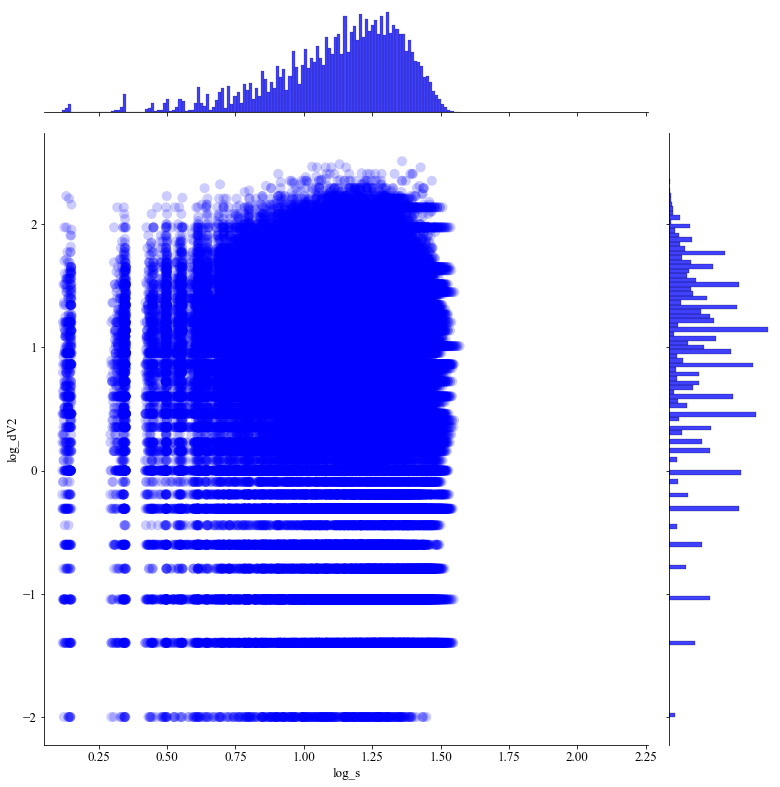

In [27]:
mask = (pairs.log_s > 0) & (pairs.log_dV2 > -4)
ax = sns.jointplot(x='log_s', y='log_dV2', data=pairs[mask], alpha=0.2, s=100, edgecolor='none', color="blue", xlim=[0.05, 2.26])
ax.fig.set_size_inches(12, 12)

In [28]:
pairs.loc[:, 's_class'] = pd.Categorical((2*pairs.log_s + 0.5).astype('int'), ordered=True)
pairs.s_class[pairs.s_class == 0] = 1

In [29]:
for j in range(5):
    print()
    print("s_class =", j)
    print(pairs[pairs.s_class == j][['dV2', 'log_s']].describe())


s_class = 0
       dV2  log_s
count  0.0    0.0
mean   NaN    NaN
std    NaN    NaN
min    NaN    NaN
25%    NaN    NaN
50%    NaN    NaN
75%    NaN    NaN
max    NaN    NaN

s_class = 1
                dV2         log_s
count  15234.000000  15234.000000
mean      10.266750      0.564501
std       16.729835      0.158497
min        0.000000      0.116664
25%        0.250000      0.494333
50%        4.000000      0.613866
75%       13.690000      0.694892
max      210.250000      0.749902

s_class = 2
                dV2         log_s
count  98822.000000  98822.000000
mean      19.347575      1.060842
std       26.362273      0.133116
min        0.000000      0.750404
25%        1.440000      0.963528
50%        9.000000      1.084100
75%       25.000000      1.175197
max      306.250000      1.249984

s_class = 3
                dV2         log_s
count  71272.000000  71272.000000
mean      13.808467      1.362096
std       22.216623      0.073223
min        0.000000      1.250018
25% 

C:\Users\ZAINTEL2\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\ZAINTEL2\anaconda3\lib\site-packages\numpy\lib\histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


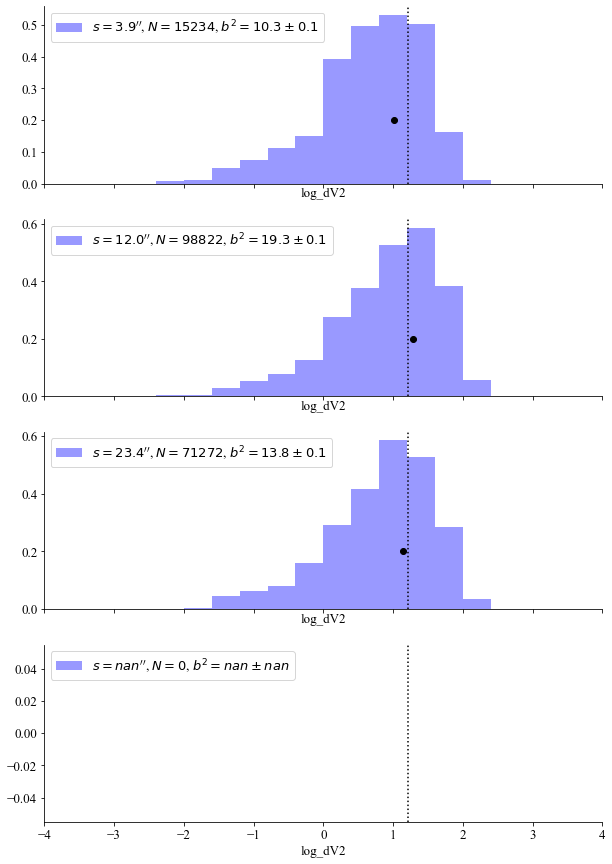

In [30]:
sig2 = pairs.dV2.mean()
sig2a = 2*np.var(df1.V)
fig, axes = plt.subplots(4, 1, figsize=(10, 15), sharex=True)
for sclass, ax in zip(range(1, 5), axes):
    b2mean = np.mean(pairs.dV2[pairs.s_class == sclass])
    b2std = np.std(pairs.dV2[pairs.s_class == sclass])
    b2mean2 = np.mean(pairs.log_dV2[pairs.s_class == sclass])
    n = np.sum(pairs.s_class == sclass)
    b2sem = b2std/np.sqrt(n)
    smean = np.mean(10**pairs.log_s[pairs.s_class == sclass])
    label = f"$s = {smean:.1f}''$"
    label += f", $N = {n}$"
    label += fr", $b^2 = {b2mean:.1f} \pm {b2sem:.1f}$"
    sns.distplot(pairs.log_dV2[pairs.s_class == sclass], 
                 norm_hist=True, kde=False, ax=ax,
                 label=label, bins=20, color="blue",hist_kws=dict(range=[-4.0, 4.0])
                )
    ax.plot([np.log10(b2mean)], [0.2], 'o', color='k')
    ax.plot([np.log10(b2mean - b2sem), np.log10(b2mean + b2sem)], [0.2]*2, lw=3, color='k')
    ax.axvline(np.log10(sig2a), color='k', ls=':')
    ax.set(xlim=[-4.0, 4.0])
    ax.legend(loc='upper left')
sns.despine()

In [31]:
print(f'Dotted line is 2 x sigma^2 = {sig2a:.2f}')

Dotted line is 2 x sigma^2 = 16.13


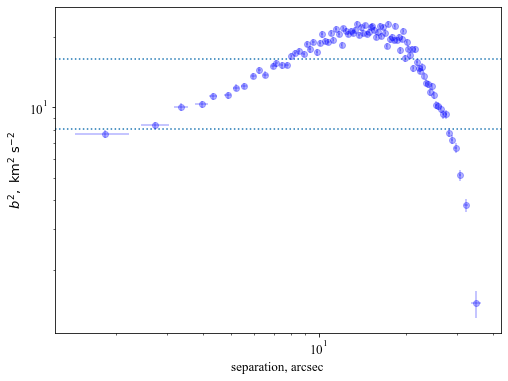

In [32]:
ngroup = 2000
groups = np.arange(len(pairs)) // ngroup
table = pairs[['s', 'dV2']].sort_values('s').groupby(groups).describe()
fig, ax = plt.subplots(figsize=(8, 6))
s = table[('s', 'mean')]
e_s = table[('s', 'std')]
b2 = table[('dV2', 'mean')]
ng = table[('dV2', 'count')]
e_b2 = table[('dV2', 'std')]/np.sqrt(ng - 1)
ax.axhline(sig2a, ls=':')
ax.axhline(0.5*sig2a, ls=':')
ax.errorbar(s, b2, yerr=e_b2, xerr=e_s, fmt='o', alpha=0.3, color="blue")
#sgrid = np.logspace(0.3, 1.65)
#ax.plot(sgrid, 38.5*sgrid**(0.8), color="k", lw=0.5)
ax.set(xscale='log', yscale='log', 
       xlabel='separation, arcsec',
       ylabel=r'$b^2,\ \mathrm{km^2\ s^{-2}}$'
      )
None

In [33]:
table=[s*pc,b2,e_s,e_b2]
dfx2=pd.DataFrame(table)
dfx2=dfx2.transpose()
dfx2=dfx2.set_axis(['pc', 'S', 'ErrX', 'ErrY'], axis=1, inplace=False)
dfx2.to_csv('SFdata//M8H2.csv',mode = 'w', index=False)

[None,
 Text(0, 0.5, '$b^2,\\ \\mathrm{km^2\\ s^{-2}}$'),
 None,
 Text(0.5, 0, 'separation, pc')]

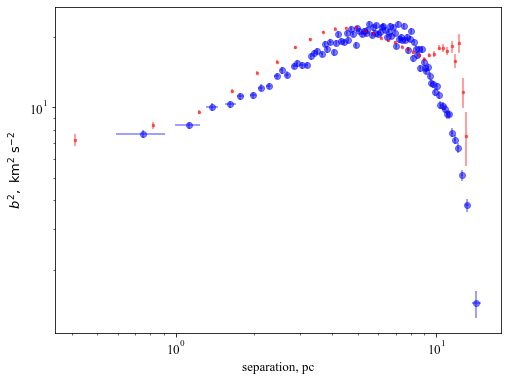

In [34]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.errorbar(s*.41, b2, yerr=e_b2, xerr=e_s*.41, fmt='o', alpha=0.5,color="blue")

ax.errorbar(SF.Lag,SF.Nmqvd, yerr=SF.ErrY, marker='.', fmt=' ',color="red", ecolor="red",
                     alpha=0.5, markersize=5)

ax.set(xscale='log', yscale='log', 
       xlabel='separation, pc',
       ylabel=r'$b^2,\ \mathrm{km^2\ s^{-2}}$'
      )

In [35]:
#fig, ax = plt.subplots(figsize=(7, 7))

#ax.errorbar(s*.145, b2, yerr=e_b2, xerr=e_s*.145, fmt='o', alpha=0.5,color="blue",label='Dr. Will')

#ax.errorbar(SF.Lag,SF.Nmqvd, yerr=SF.ErrY, marker='.', fmt=' ',color="red", ecolor="red",
#                     alpha=0.5, markersize=5,label='phd')

#lo=0.1
#ss=np.round((data['RV'].std())**2,2)
#s0=0.1

#n=0.6
#x=np.linspace(-1,(SF.Lag.max()),100)
#c=1/(1+(x/lo)**n)

#y=2*(1-c)*ss

#sgrid = np.logspace(-1, 1)
#ax.plot(sgrid, 5.2*sgrid**(0.75), color="k", lw=2, linestyle='--')

#plt.axhline(y=ss, color='r', linestyle='--')
#plt.axvline(x=s0, color='k', linestyle='--')


#plt.loglog(x,y,color='k', linestyle='-')

#sgrid = np.logspace(-1, 300)
#ax.plot(sgrid, 12*sgrid**(0.3), color="k", lw=2, linestyle='--')

#textstr = '\n'.join((r'$m=%.2f$'%n,r'm$_{--}=%.2f$'%0.75, r'$r_{0}=%.2f$' % s0+' [pc]',
#                     r'$σ_{POS}=%.2f$' % (df0["RV"].std()) + ' [km/s]' )) 

#props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
#ax.text(0.65, .5, textstr, transform=ax.transAxes, fontsize=14,
#        verticalalignment='top', bbox=props)

#ax.set(xscale='log', yscale='log', 
#       xlabel='lag [pc]', ylabel='S$_{2}$(l) [km$^{2}$/s$^{2}$]'    )

#ax.set_xlim(0.1, 200)
#ax.set_ylim(1, 1000)

#plt.legend()

#fig.savefig('SFM42.pdf', bbox_inches='tight')

In [36]:
finish=time.time()
print("Runnig time:",finish-start, "seconds" )

Runnig time: 15.460165023803711 seconds
